In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from src.model.models import MLP
from src.data.helpers import list_to_model, get_moons_dataset, rotate, get_accuracy
from src.visualization.visualize import plot_decision_boundary

path = f"../../models/autoencoders/experiment8"

In [3]:
class ModelParamsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, angle_change: int = 45):
        self.dataset_path = dataset_path
        self.dataset = pd.read_csv(dataset_path)

        self.angle_change = angle_change
        self.weights = self.dataset.drop(columns=["model_name", "angle"]).astype('float32')
        self.angles = self.dataset["angle"]*np.pi/180

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        weights = torch.tensor(self.weights.iloc[idx].values)
        angle = torch.tensor(self.angles.iloc[idx])

        return weights, angle

In [4]:
class Autoencoder(torch.nn.Module):
    def __init__(self) -> None:
        super(Autoencoder, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 1024),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1024),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(512),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(128),
            torch.nn.Linear(128, 16),
            torch.nn.Tanh(),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(16, 128),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(128),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(512),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1024),
            torch.nn.Linear(1024, 33),
        )

    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output

In [ ]:
config = {
    "model":{
        "name": "Autoencoder",
        "layers": [33, 512, 1024, 512, 256, 128, 128]
    },
    "hyperparameters":{
        "epochs": 150,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam",
    }
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]

autoencoder = Autoencoder()
autoencoder.to(device)
loss_fn = torch.nn.MSELoss()
latent_loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=weight_decay)

dataset = ModelParamsDataset("../../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

In [67]:
autoencoder.train()
for i in tqdm(range(epochs)):
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        sin = torch.sin(y)
        cos = torch.cos(y)

        l = autoencoder.encoder(X)
        lg = l.clone()
        lg[:, 0] = sin
        lg[:, 1] = cos

        output = autoencoder.decoder(l)

        rl = loss_fn(output, X)
        ll = latent_loss_fn(l, lg)
        # ll = 0

        loss = rl + ll
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if(i % 5 == 0):
        print(f'Epoch: {i+1}, Loss: {loss.item()}')
        torch.save(autoencoder.state_dict(), f"{path}/autoencoder_{i}.pth")
    
torch.save(autoencoder.state_dict(), f"{path}/autoencoder_final.pth")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1, Loss: 1.473410964012146
Epoch: 6, Loss: 0.8175191879272461
Epoch: 11, Loss: 0.597160279750824
Epoch: 16, Loss: 0.43640387058258057
Epoch: 21, Loss: 0.40761035680770874
Epoch: 26, Loss: 0.3971024453639984
Epoch: 31, Loss: 0.3417493402957916
Epoch: 36, Loss: 0.3839464485645294
Epoch: 41, Loss: 0.28790760040283203
Epoch: 46, Loss: 0.26576560735702515
Epoch: 51, Loss: 0.271091490983963
Epoch: 56, Loss: 0.2592374384403229
Epoch: 61, Loss: 0.3157474994659424
Epoch: 66, Loss: 0.25382646918296814
Epoch: 71, Loss: 0.21517018973827362
Epoch: 76, Loss: 0.27061623334884644
Epoch: 81, Loss: 0.2765645682811737
Epoch: 86, Loss: 0.216859832406044
Epoch: 91, Loss: 0.28267449140548706
Epoch: 96, Loss: 0.21498432755470276
Epoch: 101, Loss: 0.23467476665973663
Epoch: 106, Loss: 0.2306491881608963
Epoch: 111, Loss: 0.21936729550361633
Epoch: 116, Loss: 0.1853879988193512
Epoch: 121, Loss: 0.2330275923013687
Epoch: 126, Loss: 0.2757885158061981
Epoch: 131, Loss: 0.24351437389850616
Epoch: 136, Los

C:\Projects\Python\master-thesis\src\data\helpers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param.data = torch.tensor(parameters_from_list, dtype=torch.float32).reshape(param.shape)


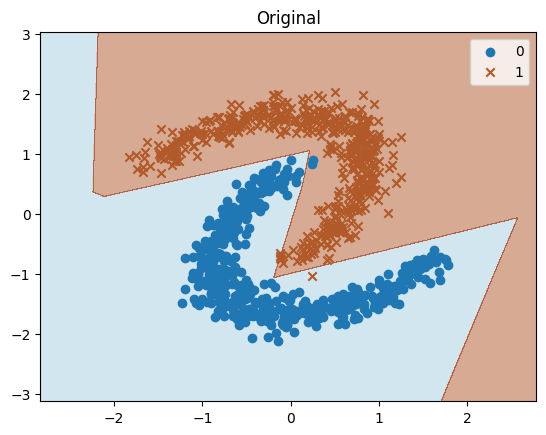

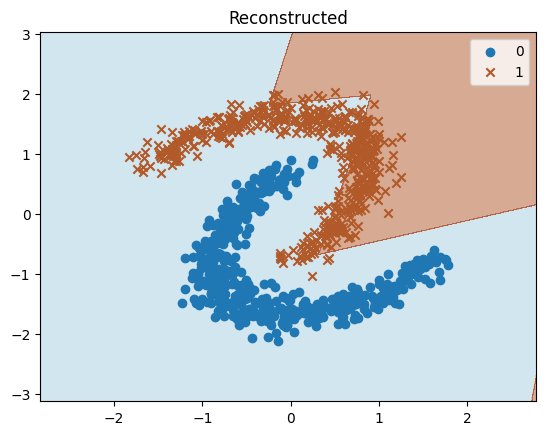

In [6]:
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load("{}/autoencoder_final.pth".format(path)))
autoencoder.eval()
model1 = MLP(2, [8], 1)
model2 = MLP(2, [8], 1)

raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()
X,y = get_moons_dataset()

index = 34930
X_rotated = rotate(X, angles[index])
w = torch.tensor(weights[index])

o = autoencoder(w.unsqueeze(0)).squeeze().detach().numpy()
list_to_model(model1, w)
list_to_model(model2, o)

plot_decision_boundary(model1, X_rotated, y, title="Original")
plot_decision_boundary(model2, X_rotated, y, title="Reconstructed")

(80000, 16)
(80000, 3)


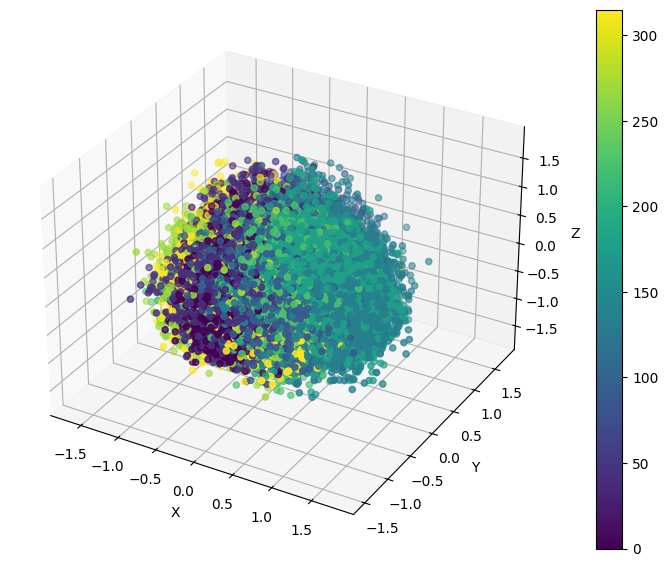

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


autoencoder = Autoencoder()
checkpoint = 95
autoencoder.load_state_dict(torch.load("{}/autoencoder_0.pth".format(path)))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

latent = autoencoder.encoder(torch.tensor(weights).float()).detach().numpy()
print(latent.shape)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent)
print(X_pca.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.view_init(0, 0, 90)

plt.show()

(80000, 16)
(80000, 3)


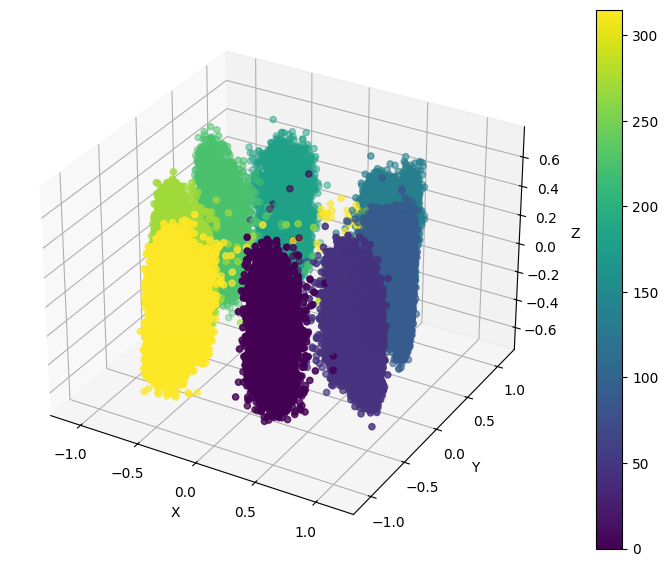

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


autoencoder = Autoencoder()
checkpoint = 95
autoencoder.load_state_dict(torch.load("{}/autoencoder_75.pth".format(path)))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

latent = autoencoder.encoder(torch.tensor(weights).float()).detach().numpy()
print(latent.shape)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent)
print(X_pca.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.view_init(0, 0, 90)

plt.show()

(80000, 16)
(80000, 3)


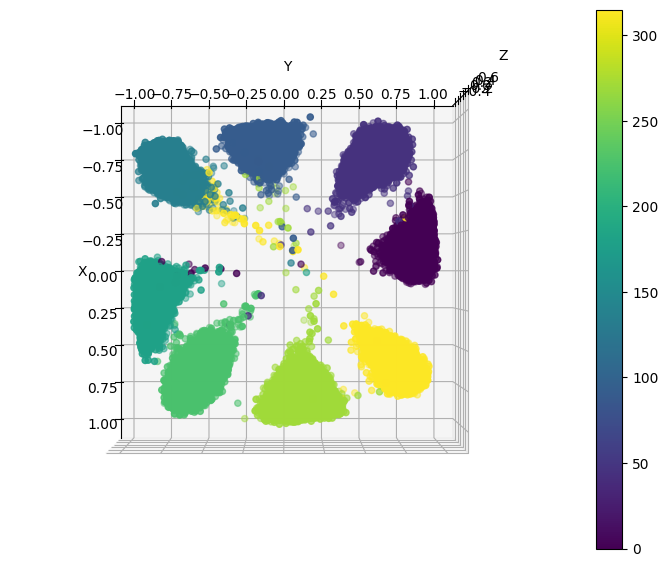

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


autoencoder = Autoencoder()
checkpoint = 95
autoencoder.load_state_dict(torch.load("{}/autoencoder_final.pth".format(path)))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

latent = autoencoder.encoder(torch.tensor(weights).float()).detach().numpy()
print(latent.shape)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent)
print(X_pca.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(90, 0, 0)

plt.show()

C:\Projects\Python\master-thesis\src\data\helpers.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param.data = torch.tensor(parameters_from_list, dtype=torch.float32).reshape(param.shape)


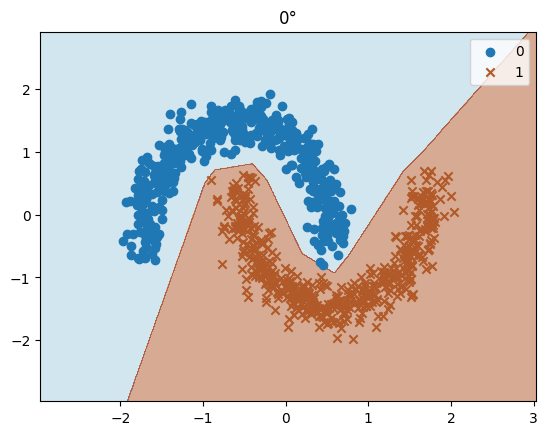

In [8]:
raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()
X,y = get_moons_dataset()

autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load("{}/autoencoder_final.pth".format(path)))
autoencoder.eval()
model = MLP(2, [8], 1)

index = 0
w = weights[index]
w = torch.tensor(w).float()
a = angles[index]

# l = autoencoder.encoder(w)
# s = torch.sin(torch.tensor(45*np.pi/180))
# c = torch.cos(torch.tensor(45*np.pi/180))
# l[0] = s
# l[1] = c

# o = autoencoder.decoder(l).detach().numpy()

X_rotated = rotate(X, a)
list_to_model(model, w)

plot_decision_boundary(model, X_rotated, y, title=f"{a}°")

## With extra angles

(100000, 16)
(100000, 3)


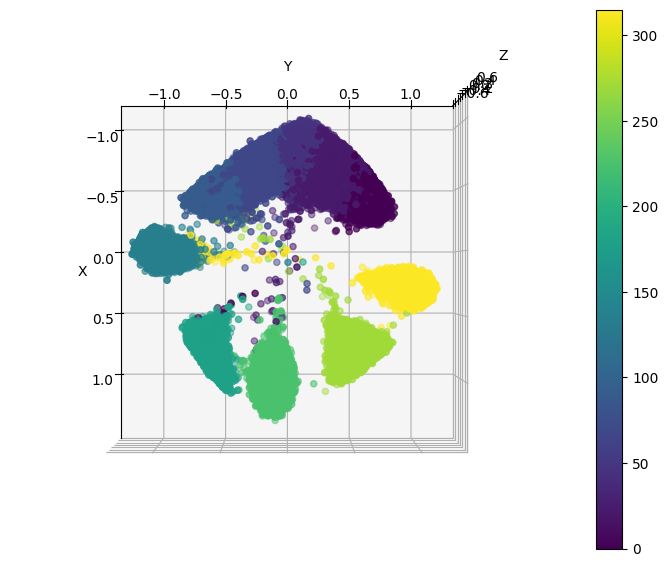

In [65]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


autoencoder = Autoencoder()
checkpoint = 95
autoencoder.load_state_dict(torch.load("{}/autoencoder_final.pth".format(path)))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
extra = pd.read_csv("../data/extra_angles.csv")
raw = pd.concat([raw, extra])
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

latent = autoencoder.encoder(torch.tensor(weights).float()).detach().numpy()
print(latent.shape)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent)
print(X_pca.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], -X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(90, 0, 0)

plt.show()

(10000, 16)
[ 0.75116694  0.31608585  0.01681182  0.04568607 -0.00149487 -0.00350557
 -0.02090614  0.01603163  0.00189478 -0.05985357  0.00319915  0.01111363
  0.02097854  0.00126441  0.00526116  0.00553812]


<BarContainer object of 16 artists>

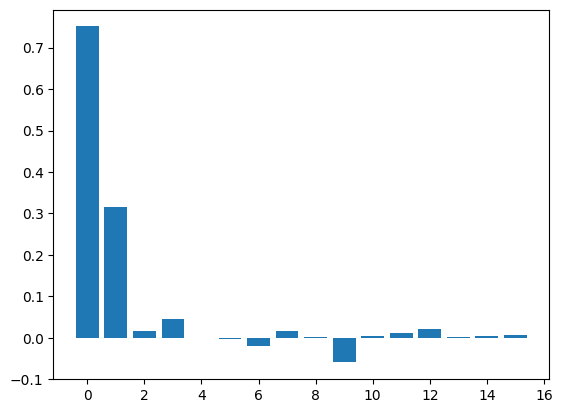

In [100]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load("{}/autoencoder_final.pth".format(path)))
autoencoder.eval()

raw = pd.read_csv("../data/extra_angles.csv")
raw = raw[raw["angle"] == 67]
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

latent = autoencoder.encoder(torch.tensor(weights).float()).detach().numpy()
print(latent.shape)

latent = np.sum(latent, axis=0)/latent.shape[0]

print(latent)

plt.bar(range(16), latent)

## Trained models

In [4]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})

C:\Projects\Python\master-thesis\src\data\helpers.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param.data = torch.tensor(parameters_from_list, dtype=torch.float32).reshape(param.shape)


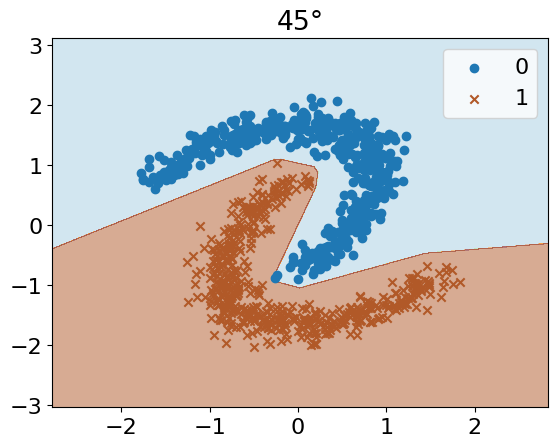

In [33]:
raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()
X, y = get_moons_dataset()

index = 63000
w = weights[index]
w = torch.tensor(w).float()
a = angles[index]
X_rotated = rotate(X, a)

model = MLP(2, [8], 1)
list_to_model(model, w)

plot_decision_boundary(model, X_rotated, y, title=f"{a}°")

## Sample

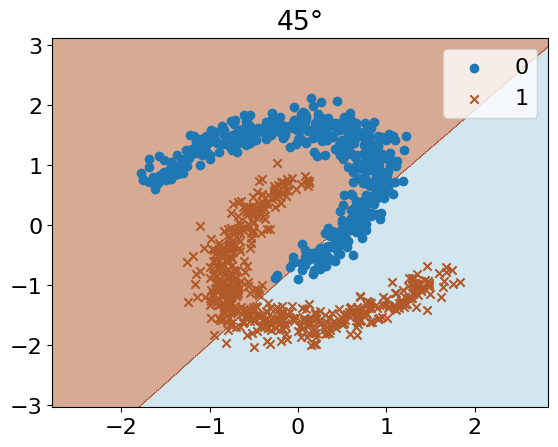

In [35]:
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load("{}/autoencoder_final.pth".format(path)))
autoencoder.eval()

model = MLP(2, [8], 1)

X,y = get_moons_dataset()

angle = 45

latent = torch.rand(1, 16)*2-1
latent[0, 0] = np.sin(angle*np.pi/180)
latent[0, 1] = np.cos(angle*np.pi/180)
X_rotated = rotate(X, angle)

output = autoencoder.decoder(latent).squeeze().detach().numpy()
list_to_model(model, output)

plot_decision_boundary(model, X_rotated, y, title="45°")

## Interpolate

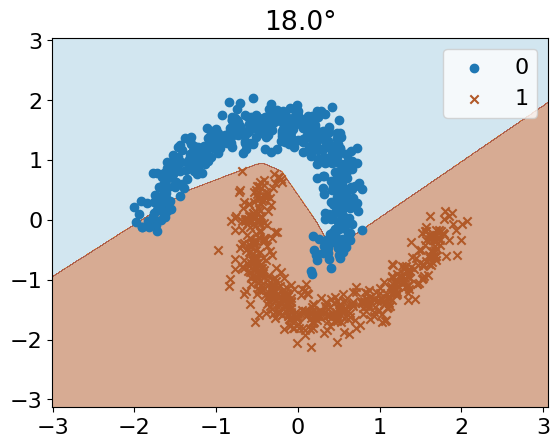

In [38]:
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load("{}/autoencoder_final.pth".format(path)))
autoencoder.eval()
model = MLP(2, [8], 1)

raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()
X,y = get_moons_dataset()

w0 = weights[angles == 0]
w45 = weights[angles == 45]

index = 0
alpha = 0.4
w = torch.tensor( (1-alpha)*w0[index] + alpha*w45[index] ).unsqueeze(0).float()
a = (1-alpha)*0 + alpha*45

X_rotated = rotate(X, a)

o = autoencoder(w).squeeze().detach().numpy()
list_to_model(model, o)

plot_decision_boundary(model, X_rotated, y, title=f"{a}°")

## Reconstructed Accuracy

In [17]:
class MLP(nn.Module):
    def __init__(self, autoencoder=None, use_autoencoder=True):
        super(MLP, self).__init__()
        
        self.use_autoencoder = use_autoencoder
        self.autoencoder = autoencoder

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, parameters, grid, first_batch=False):
        if(self.use_autoencoder):
            parameters = self.autoencoder(parameters)
        
        if(first_batch):
            weights_1 = parameters[:, :16].reshape(-1, 8, 2).transpose(1, 2)
            bias_1 = parameters[:, 16:24].reshape(-1, 8)
            weights_2 = parameters[:, 24:32].reshape(-1, 1,8).transpose(1, 2)
            bias_2 = parameters[:, 32:33].reshape(-1, 1)

            bias_1 = bias_1.unsqueeze(1).repeat(1, grid.shape[1], 1)
            bias_2 = bias_2.unsqueeze(1).repeat(1, grid.shape[1], 1)
        
            x = torch.bmm(grid, weights_1) + bias_1
            x = self.relu(x)

            x = torch.bmm(x, weights_2) + bias_2
        else:
            weights_1 = parameters[:16].reshape(8, 2).T
            bias_1 = parameters[16:24].reshape(8)
            weights_2 = parameters[24:32].reshape(1,8).T
            bias_2 = parameters[32:33].reshape(1)

            x = torch.matmul(grid, weights_1) + bias_1
            x = self.relu(x)

            x = torch.matmul(x, weights_2) + bias_2


        x = self.sigmoid(x) 
        return x
    
def get_accuracy(model, parameters, X, y):
    '''
    Get the accuracy of a Moons classifier on a moons dataset.
    '''
    y_pred = model(parameters, X, True)
    y_pred = y_pred.squeeze().round().detach().numpy()
    correct = (y_pred == y).sum()
    accuracy = correct / len(y) * 100
    return accuracy

In [10]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

  0%|          | 0/80000 [00:00<?, ?it/s]

Mean trained accuracy: 99.87490625000002
Mean reconstructed accuracy: 98.85750250000001


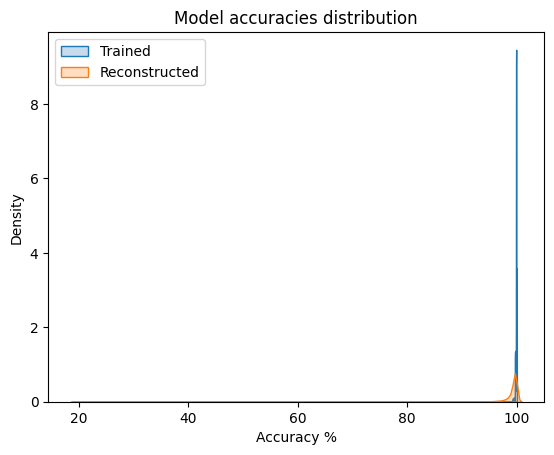

In [21]:
tester = MLP(use_autoencoder=False)
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load(f"{path}/autoencoder_final.pth"))
model = MLP(autoencoder=autoencoder)
dataset = ModelParamsDataset("../data/eight_angles_small.csv")

tester.eval()
model.eval()

trained_accuracies = []
reconstructed_accuracies = []

X, y = get_moons_dataset()

for (parameter, angle) in tqdm(dataset):
    parameter = parameter.unsqueeze(0)
    X_rotated = rotate(X, angle*180/np.pi)
    X_rotated = torch.tensor(X_rotated).float().unsqueeze(0)
    accuracy = get_accuracy(tester, parameter, X_rotated, y)
    trained_accuracies.append(accuracy)

    accuracy = get_accuracy(model, parameter, X_rotated, y)
    reconstructed_accuracies.append(accuracy)

print(f"Mean trained accuracy: {np.mean(trained_accuracies)}")
print(f"Mean reconstructed accuracy: {np.mean(reconstructed_accuracies)}")

sns.kdeplot(trained_accuracies, fill=True, label="Trained")
sns.kdeplot(reconstructed_accuracies, fill=True, label="Reconstructed")

plt.legend(loc="upper left")
plt.title("Model accuracies distribution")
plt.xlabel("Accuracy %")
plt.show()


## Interpolation

  0%|          | 0/8 [00:00<?, ?it/s]

Mean interpolation accuracy: 71.20802499999999


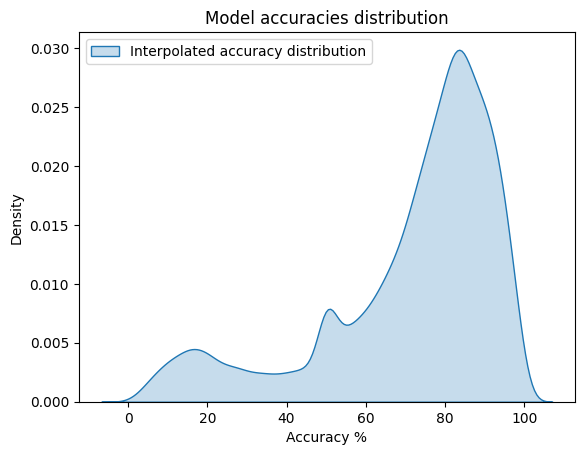

In [23]:
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load(f"{path}/autoencoder_final.pth"))

model = MLP(autoencoder)

raw = pd.read_csv("../data/eight_angles_small.csv")
weights_0 = raw.loc[raw["angle"] == 0].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_45 = raw.loc[raw["angle"] == 45].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_90 = raw.loc[raw["angle"] == 90].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_135 = raw.loc[raw["angle"] == 135].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_180 = raw.loc[raw["angle"] == 180].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_225 = raw.loc[raw["angle"] == 225].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_270 = raw.loc[raw["angle"] == 270].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_315 = raw.loc[raw["angle"] == 315].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()

weights = [weights_0, weights_45, weights_90, weights_135, weights_180, weights_225, weights_270, weights_315]
angles = [0, 45, 90, 135, 180, 225, 270, 315]

X, y = get_moons_dataset()
accuracies = []

for i in tqdm(range(-1, 7)):
    for j in range(10000):
        weight_1 = weights[i][j]
        weight_2 = weights[i+1][j]
        angle_1 = angles[i]
        angle_2 = angles[i+1]

        alpha = np.random.uniform(0.4, 0.6)
        w = (1-alpha)*weight_1 + alpha*weight_2
        angle = (1-alpha)*angle_1 + alpha*angle_2

        w = torch.tensor(w).float().unsqueeze(0)
        X_rotated = rotate(X, angle)
        X_rotated = torch.tensor(X_rotated).float().unsqueeze(0)
        accuracy = get_accuracy(tester, w, X_rotated, y)
        accuracies.append(accuracy)
    
print("Mean interpolation accuracy:", np.mean(accuracies))

sns.kdeplot(accuracies, fill=True, label="Interpolated accuracy distribution")

plt.legend(loc="upper left")
plt.title("Model accuracies distribution")
plt.xlabel("Accuracy %")
plt.show()